In [37]:
# Import Dependencies 
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd

In [39]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [41]:
# Set Engine
engine = create_engine("sqlite:///hawaii.sqlite")

Explore Database

In [42]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [43]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [44]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [45]:
# Reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [46]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [47]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [48]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Precipitation Analysis

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# View the first date in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [50]:
# Calculate the date 1 year ago from the last data point in the database
one_year_interval_before = dt.date(2017,8,23) - dt.timedelta(days=365)
print("Query Date: ", one_year_interval_before)

Query Date:  2016-08-23


In [51]:
# Perform a query to retrieve the data and precipitation scores
results_pre = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= dt.date(2016,8,23)).all()

In [52]:
# Save the query results as a Pandas DataFrame, set the index to the date column, and sort the dataframe by date
df = pd.DataFrame(results_pre, columns=['date', 'prcp'])
df.set_index('date', inplace=True, )
df = df.sort_values(by='date')
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


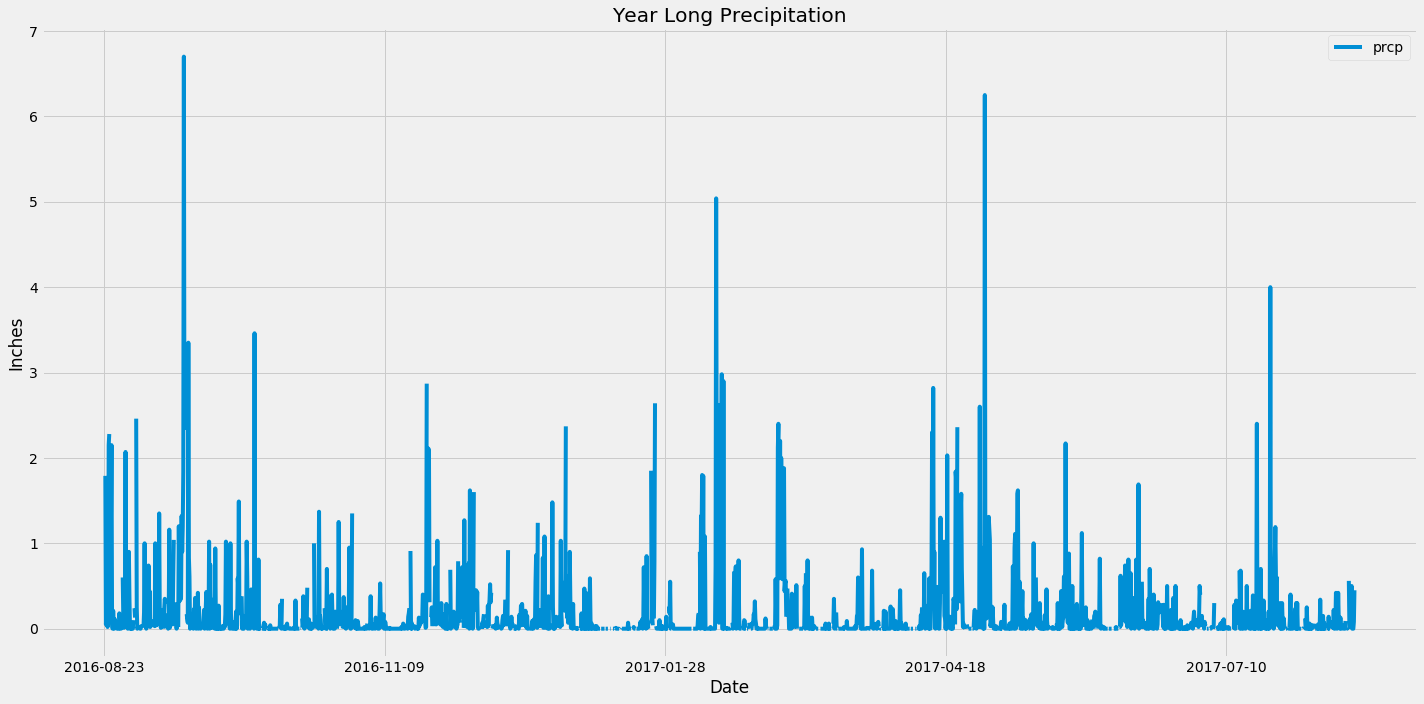

In [53]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
df.plot(ax = ax, x_compat = True)

# Add Title, X-axis Label, Y-axis label
plt.title("Year Long Precipitation")
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [54]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis

In [55]:
# Design a query to show how many stations are available in this dataset?
# Query for Stattion Count
session.query(Measurement.station).distinct().count()

9

In [56]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# Query number of observations per station
station_count = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_count  

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# Query for temperture stats (min, max, avg)
# Filter for stations equal to USC00519281
sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs)]
temp_averages = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()
temp_averages

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [58]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Query for temperture from USC00519281 for one year
results_USC00519281 = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= dt.date(2016,8,23)).all()
results_USC00519281

# Save as a data frame
df = pd.DataFrame(results_USC00519281)
df

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


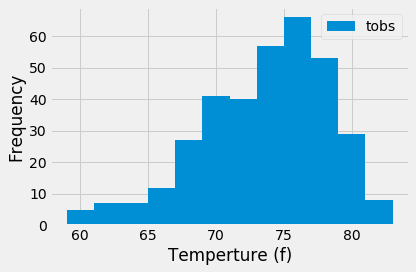

In [59]:
# Plot Histogram  
df.plot(kind='hist',bins = 12)

# Add labels and Plot
plt.xlabel('Temperture (f)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()